In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
# import librosa
import audioread
import io
import os
import re
import string
from pydub import AudioSegment
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

2024-11-22 02:59:53.288283: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 02:59:53.301444: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 02:59:53.473825: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-22 02:59:53.477302: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 02:59:55.065288: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
print(np.__version__)
print(tf.__version__)
import warnings
warnings.filterwarnings('ignore')


1.24.3
2.13.1


In [3]:
BATCH_SIZE=32
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

In [4]:
transcripts = pd.read_csv('Dataset/data.csv')

transcripts.head()

,path,sentence
0,common_voice_id_39599471.mp3,dia tidak sepenuhnya mempercayaiku
1,common_voice_id_32165882.mp3,aku juga tidak mengerti
2,common_voice_id_27657418.mp3,berharap kau di sini
3,common_voice_id_23033570.mp3,maha suci allah
4,common_voice_id_40088845.mp3,pada akhirnya dia memilih anak kucing yang sat...


2024-11-22 02:59:58.074109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 02:59:58.074723: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-11-22 02:59:58.170660: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX AVX2 AVX512F FMA


(130176,)


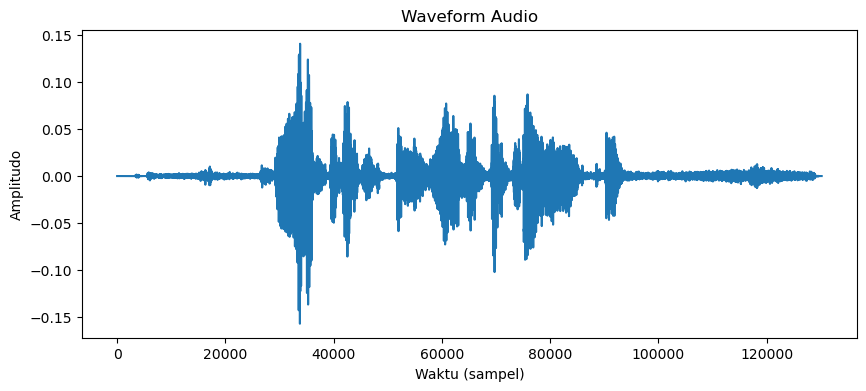

In [5]:
audio_binary = tf.io.read_file("Dataset/clips/common_voice_id_39599471.mp3")
audio = tfio.audio.decode_mp3(audio_binary)
waveform = tf.squeeze(audio,axis=-1)
waveform = tf.cast(waveform,tf.float32)
signal = waveform
print(signal.shape)

# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(signal)
plt.title("Waveform Audio")
plt.xlabel("Waktu (sampel)")
plt.ylabel("Amplitudo")
plt.show()


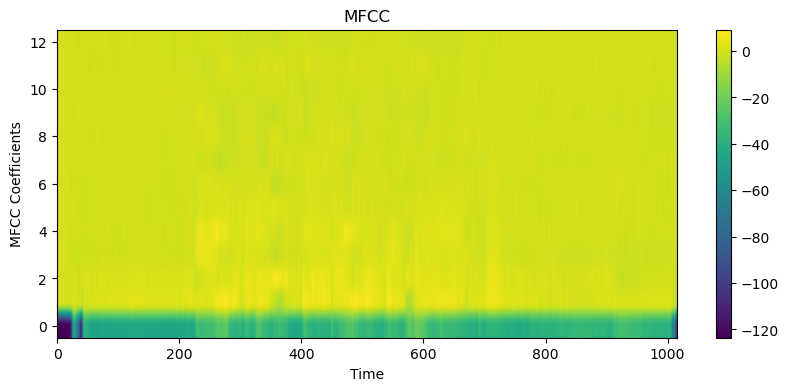

In [6]:
# Parameter STFT dan Mel
frame_length = 256
frame_step = 128
num_mel_bins = 40
num_mfccs = 13

# Ekstraksi STFT dan Mel spectrogram
stft = tf.signal.stft(waveform, frame_length=frame_length, frame_step=frame_step)
spectrogram = tf.abs(stft)

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=num_mel_bins, num_spectrogram_bins=spectrogram.shape[-1], sample_rate=16000
)
mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

# Ekstraksi MFCC
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :num_mfccs]

# Plot MFCC
plt.figure(figsize=(10, 4))
plt.imshow(mfccs.numpy().T, aspect='auto', origin='lower')
plt.title("MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()


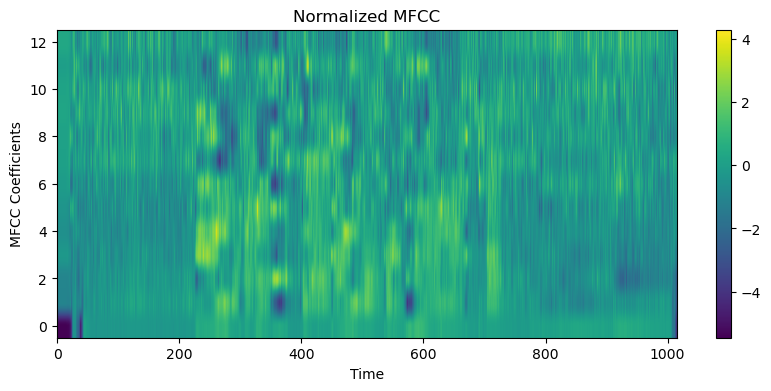

In [7]:
# Normalisasi MFCC
mean_mfcc = tf.reduce_mean(mfccs, axis=0)
std_dev_mfcc = tf.math.reduce_std(mfccs, axis=0)

# Z-score Normalization
normalized_mfccs = (mfccs - mean_mfcc) / (std_dev_mfcc + 1e-6)

# Plot MFCC yang sudah dinormalisasi
plt.figure(figsize=(10, 4))
plt.imshow(normalized_mfccs.numpy().T, aspect='auto', origin='lower')
plt.title("Normalized MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

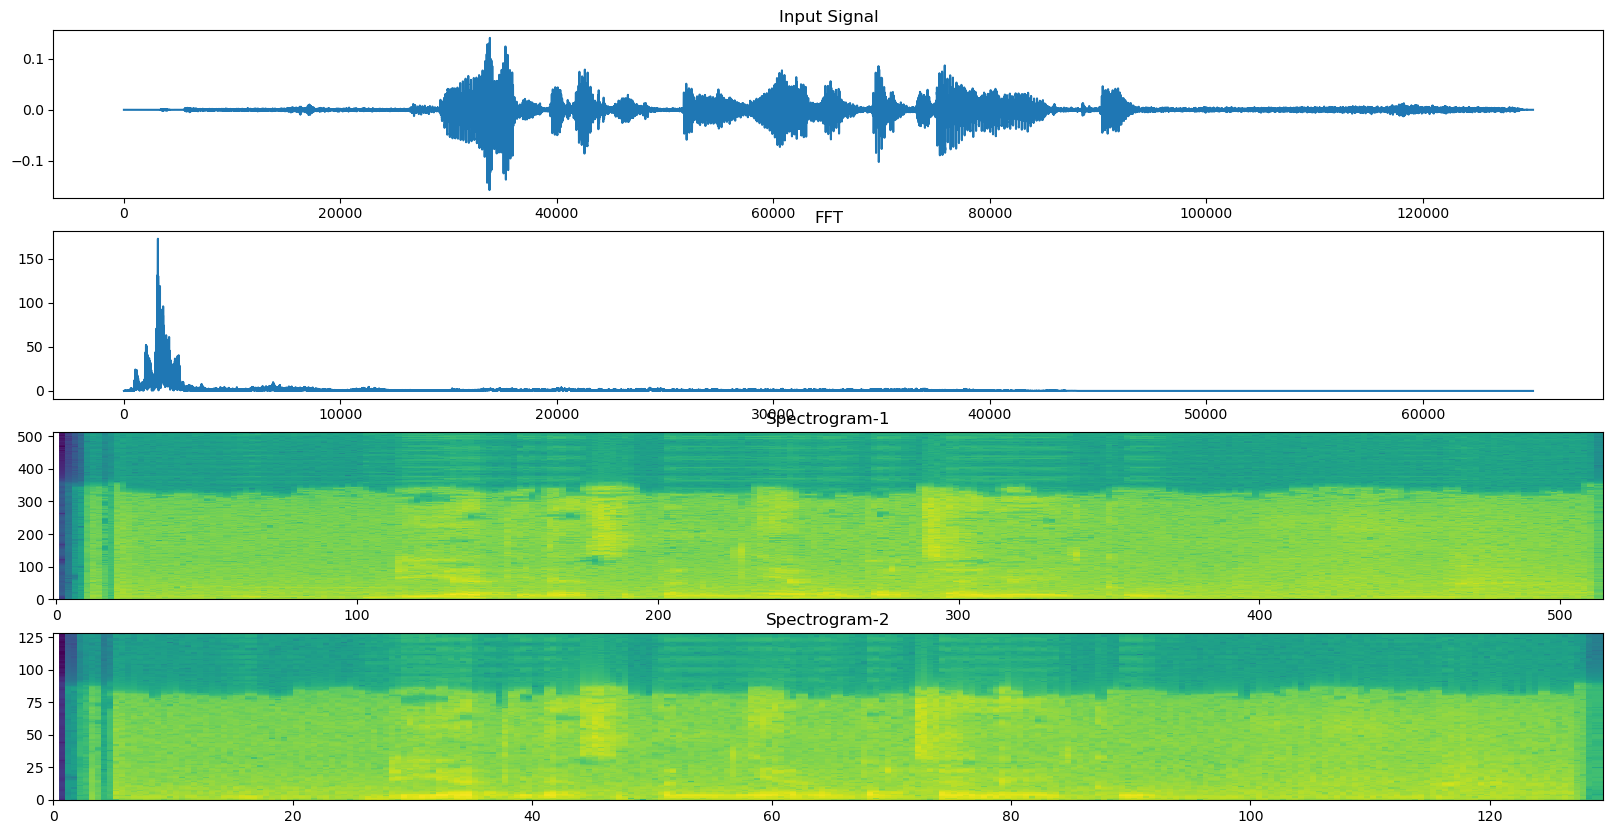

In [8]:
# Membuat 4 subplot dengan ukuran figure 20x10
fig, axis = plt.subplots(4, figsize=(20, 10))

# Definisi panjang sinyal dan sumbu x untuk plotting
L = 2000
x = tf.linspace(-L // 2, L // 2, L)

# Plot sinyal input
axis[0].plot(signal)
axis[0].set_title("Input Signal")

# Menghitung FFT (Fast Fourier Transform) dari sinyal
fft = tf.signal.rfft(signal)

# Plot magnitudo FFT
axis[1].plot(tf.abs(fft))
axis[1].set_title("FFT")

# Menghitung dan memvisualisasikan spektrogram dengan frame_length 1024
spec = tf.signal.stft(signal, frame_length=1024, frame_step=512)
spec = tf.transpose(tf.abs(spec), [1, 0])  # Transpose untuk format visualisasi
power_spec = np.log(spec)  # Mengambil logaritma untuk representasi power
height = power_spec.shape[0]
width = power_spec.shape[1]

# Membuat mesh grid untuk plotting spektrogram
X = np.linspace(0, power_spec.shape[0], num=width, dtype=int)
Y = range(height)

# Plot spektrogram pertama
axis[2].pcolormesh(X, Y, power_spec)
axis[2].set_title("Spectrogram-1")

# Menghitung dan memvisualisasikan spektrogram dengan frame_length 256
spec = tf.signal.stft(signal, frame_length=256, frame_step=128)
spec = tf.transpose(tf.abs(spec), [1, 0])
power_spec = np.log(spec)
height = power_spec.shape[0]
width = power_spec.shape[1]

# Membuat mesh grid untuk plotting spektrogram kedua
X = np.linspace(0, power_spec.shape[0], num=width, dtype=int)
Y = range(height)

# Plot spektrogram kedua
axis[3].pcolormesh(X, Y, power_spec)
axis[3].set_title("Spectrogram-2")

# Menampilkan semua plot
plt.show()


In [9]:
import csv

csv_path = "Dataset/data.csv"
audio_text = {}

# Membuka file CSV
with open(csv_path, encoding="utf-8") as f:
    reader = csv.reader(f)
    next(reader)  # skip header
    for line in reader:
        i = line[0]  # Mendapatkan kolom path audio
        text = line[1]  # Mendapatkan kolom transkript
        audio_text[str(i)] = text  # Menyimpan ke dictionary

# Menampilkan 5 item pertama dari dictionary
list(audio_text.items())[:5]


[('common_voice_id_39599471.mp3', 'dia tidak sepenuhnya mempercayaiku'),
 ('common_voice_id_32165882.mp3', 'aku juga tidak mengerti'),
 ('common_voice_id_27657418.mp3', 'berharap kau di sini'),
 ('common_voice_id_23033570.mp3', 'maha suci allah'),
 ('common_voice_id_40088845.mp3',
  'pada akhirnya dia memilih anak kucing yang satunya')]

In [10]:
# list file audio
filepaths = ["Dataset/clips/" + filename for filename in list(audio_text.keys())]

# list transkript
sentence = [text for text in audio_text.values()]

print(len(filepaths))
print(len(sentence))

29617
29617


In [11]:
# Membuat dataset dari pasangan file audio dan transkripsi teks
dataset = tf.data.Dataset.from_tensor_slices((filepaths, sentence))

In [12]:
# print 1 element dari dataset
for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'Dataset/clips/common_voice_id_39599471.mp3'>, <tf.Tensor: shape=(), dtype=string, numpy=b'dia tidak sepenuhnya mempercayaiku'>)


In [13]:
# decode file audio MP3
def decode_audio(audio_binary):
    # Decode file audio dari format biner menjadi tensor audio
    audio = tf.audio.decode_mp3(audio_binary)
    # Menghapus dimensi tambahan (-1) agar menghasilkan tensor 1D
    return tf.squeeze(audio, axis=-1)


In [14]:
# Membuat daftar vocabulary untuk pengkodean tekz
vocabulary = [""] + [chr(i) for i in range(97, 97 + 26)]
print(vocabulary ) 
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27


In [15]:
# mengonversi teks (label) menjadi representasi numerik berdasarkan vocabulary
def get_label(label):
    # Memisahkan string menjadi karakter Unicode
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    
    # Mengonversi karakter ke indeks numerik berdasarkan vocabulary
    # Menggunakan StringLookup untuk mencocokkan setiap karakter ke indeks di vocabulary
    # oov_token="" digunakan untuk karakter yang tidak ada dalam vocabulary
    label = tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    
    return label



In [16]:
# menghasilkan spektrogram dari file audio dan mengonversi label ke bentuk numerik
def get_spec(filepath, label):
    # Membaca file audio
    audio_binary = tf.io.read_file(filepath)
    
    # Dekode file audio MP3 menjadi waveform
    audio = tfio.audio.decode_mp3(audio_binary)
    
    # Mengonversi waveform ke tipe data float32
    waveform = tf.cast(audio, tf.float32)
    
    # Menghitung spektrogram dengan Short-Time Fourier Transform (STFT)
    spectrogram = tf.signal.stft(waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
    
    # Mengambil magnitudo dari spektrogram
    spectrogram = tf.abs(spectrogram)
    
    # Mengonversi label teks menjadi numerik dengan fungsi get_label
    label = get_label(label)
    
    # Return spektrogram dengan dimensi tambahan (-1) dan label
    return tf.expand_dims(spectrogram, axis=-1), label


In [17]:
# Proses dataset dengan menerapkan fungsi get_spec untuk menghasilkan spektrogram dan label
processed_dataset = (
    # Mengaplikasikan fungsi get_spec ke setiap elemen dalam dataset
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    # Mengelompokkan data menjadi batch dengan ukuran yang ditentukan oleh BATCH_SIZE
    .padded_batch(BATCH_SIZE)
    # Mengoptimalkan pembacaan data dengan prefetching untuk mempercepat proses
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [18]:
# spectrogram shapes
for spectrogram, label in processed_dataset.take(1):
    print(f"Spectrogram shape: {spectrogram.shape}")
    print(f"Label shape: {label.shape}")


Spectrogram shape: (32, 268416, 0, 129, 1)
Label shape: (32, 81)


In [19]:
# Membagi dataset yang telah diproses menjadi dataset untuk pelatihan dan validasi
train_dataset = processed_dataset.take(int(0.95 * len(processed_dataset)))
val_dataset = processed_dataset.skip(int(0.95 * len(processed_dataset)))

In [20]:
print("Train cardinality:", train_dataset.cardinality().numpy())
print("Validation cardinality:", val_dataset.cardinality().numpy())


Train cardinality: 879
Validation cardinality: 47


In [21]:
# Mengambil dan menampilkan elemen pertama dari train_dataset
for i, j in train_dataset.take(1):
    print(i, j)

tf.Tensor([], shape=(32, 268416, 0, 129, 1), dtype=float32) tf.Tensor(
[[ 4  9  1 ...  0  0  0]
 [ 1 11 21 ...  0  0  0]
 [ 2  5 18 ...  0  0  0]
 ...
 [19  9  0 ... 14 25  1]
 [ 1 16  1 ...  0  0  0]
 [19  1 25 ...  0  0  0]], shape=(32, 81), dtype=int64)


In [22]:
# Membuat layer normalisasi dari Keras
normalization = tf.keras.layers.Normalization()

In [23]:
# Input layer untuk spektrogram dengan bentuk (None, 129, 1), yang berarti 
# panjang variabel, 129 fitur frekuensi, dan 1 saluran (mono)
input_spectrogram = Input((None, 129, 1), name="input")

# Normalisasi input spektrogram untuk memastikan data memiliki distribusi yang seragam
x = normalization(input_spectrogram)

# Convolutional Layer pertama: 32 filter dengan ukuran kernel (11, 41), strides (2, 2),
# padding 'same' untuk mempertahankan dimensi input, dan fungsi aktivasi ReLU
x = Conv2D(32, kernel_size=[11, 41], strides=[2, 2], padding='same', activation='relu')(x)

# Layer normalisasi untuk output dari Conv2D
x = LayerNormalization()(x)

# Convolutional Layer kedua: 64 filter dengan ukuran kernel (11, 21), strides (1, 2),
# padding 'same', dan fungsi aktivasi ReLU
x = Conv2D(64, kernel_size=[11, 21], strides=[1, 2], padding='same', activation='relu')(x)

# Layer normalisasi untuk output dari Conv2D kedua
x = LayerNormalization()(x)

# Mengubah bentuk output dari Conv2D untuk memasukkan data ke dalam layer Recurrent
x = Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

# Bidirectional GRU Layer pertama dengan 128 unit, menghasilkan output berurutan (return_sequences=True)
x = Bidirectional(GRU(128, return_sequences=True))(x)

# Bidirectional GRU Layer kedua dengan 128 unit, menghasilkan output berurutan (return_sequences=True)
x = Bidirectional(GRU(128, return_sequences=True))(x)

# Bidirectional GRU Layer ketiga dengan 128 unit, menghasilkan output berurutan (return_sequences=True)
x = Bidirectional(GRU(128, return_sequences=True))(x)

# Dense layer untuk output dengan jumlah unit sebanyak panjang vocabulary + 1 (untuk token OOV),
# menggunakan fungsi aktivasi softmax untuk klasifikasi multi-kelas
output = Dense(len(vocabulary) + 1, activation="softmax")(x)

# Membuat model dengan input spektrogram dan output hasil prediksi
model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2_Inspired")

# Menampilkan ringkasan arsitektur model
model.summary()


Model: "DeepSpeech_2_Inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization (Normalizati  (None, None, 129, 1)      3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (Layer  (None, None, 65, 32)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Lay  (None, None, 33,

In [24]:
def ctc_loss(y_true,y_pred):
    batch_size=tf.shape(y_pred)[0]
    pred_length=tf.shape(y_pred)[1]
    true_length=tf.shape(y_true)[1]

    pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
    true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)

    return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [25]:
model.compile(
    loss=ctc_loss,  # Menggunakan custom CTC loss function
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),  # Menggunakan Adam optimizer
)

In [26]:
history = model.fit(
    train_dataset,  # Data pelatihan
    validation_data=val_dataset,  # Data validasi
    verbose=1,  # Menampilkan progres pelatihan
    epochs=N_EPOCHS  # Jumlah epoch untuk pelatihan
)

Epoch 1/100


ValueError: in user code:

    File "/home/rafli/anaconda3/envs/py310/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/rafli/anaconda3/envs/py310/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/rafli/anaconda3/envs/py310/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/rafli/anaconda3/envs/py310/lib/python3.8/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/home/rafli/anaconda3/envs/py310/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/rafli/anaconda3/envs/py310/lib/python3.8/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'DeepSpeech_2_Inspired' (type Functional).
    
    Input 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, None, None, 129)
    
    Call arguments received by layer 'DeepSpeech_2_Inspired' (type Functional):
      • inputs=tf.Tensor(shape=(None, None, None, 129, 1), dtype=float32)
      • training=True
      • mask=None
